In [34]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
import timm
import numpy as np
import random
from torch.utils.data import random_split
import torch.nn.functional as F
import pickle
import matplotlib.pyplot as plt

In [35]:
class Model(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(Model, self).__init__()

        # Load a pretrained resnet model from torchvision.models in Pytorch
        self.model = timm.create_model('inception_resnet_v2', pretrained=False)

        # Change the input layer to take Grayscale image, instead of RGB images. 
        # Hence in_channels is set as 1 or 3 respectively
        # original definition of the first layer 
        # self.conv1 = Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.model.conv2d_1a.conv = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, bias=False)
    
        # Change the output layer to output 10 classes instead of 1000 classes
        num_ftrs = self.model.classif.in_features
        self.model.classif = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

In [36]:
class SiameseDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __getitem__(self, index):
        img1, label1 = random.choice(self.dataset)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0, 1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img2, label2 = random.choice(self.dataset) 
                if label1 == label2:
                    break
        else:
            while True:
                #Look untill a different class image is found
                img2, label2 = random.choice(self.dataset) 
                if label1 != label2:
                    break
        
        return img1, img2, torch.from_numpy(np.array([int(label1 != label2)], dtype=np.float32))
    
    def __len__(self):
        return len(self.dataset)

In [37]:
transform = transforms.Compose([
    transforms.Resize(139),    # minimum image size for inception resnet
    transforms.ToTensor(),
])

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

train_len = int(0.8 * len(training_data))
val_len = len(training_data) - train_len
torch.manual_seed(42)
train_data, val_data = random_split(training_data, [train_len, val_len])

In [38]:
train_datas = SiameseDataset(train_data)

In [39]:
train_datas[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([1.]))

In [3]:
test_data = SiameseDataset('test.pickle')

In [30]:
test_data[0]

(tensor([0.3820, 0.1963, 0.2421,  ..., 0.3875, 0.6740, 0.1132]),
 tensor([0.8530, 0.1196, 0.4697,  ..., 0.1243, 0.0000, 0.0381]),
 tensor([0.]))

In [44]:
train_data = SiameseDataset('train.pickle')
val_data = SiameseDataset('val.pickle')

KeyboardInterrupt: 

In [31]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) + 
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [40]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(1536, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, input1, input2):
        combined_features = input1 * input2
        
        return self.fc(combined_features)

In [133]:
model = SiameseNetwork()

In [134]:
model(torch.randn((5, 1536)), torch.randn((5, 1536)))

tensor([[0.3439],
        [0.3962],
        [0.5869],
        [0.4939],
        [0.5607]], grad_fn=<SigmoidBackward0>)

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [42]:
model = SiameseNetwork()
model = model.to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

In [43]:
batch_size = 32

# Create data loaders.
# train_dataloader = DataLoader(SiameseNetworkDataset(train_data), batch_size=batch_size)
# val_dataloader = DataLoader(SiameseNetworkDataset(val_data), batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [44]:
len(test_dataloader)

313

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

feature_model = Model()
feature_model.load_state_dict(torch.load('results/classifier/model19.pth'))
feature_model.model.classif = nn.Identity()
feature_model.to(device)
feature_model.eval()

In [49]:
train_datas = SiameseDataset(train_data)
val_datas = SiameseDataset(val_data)
test_datas = SiameseDataset(test_data)

test_dataloader = DataLoader(test_datas, batch_size=batch_size)

In [50]:
loss_history = []
correct_history = []

# Iterate throught the epochs
for epoch in tqdm(range(100)):

    total_loss, correct = 0, 0
    
    # Iterate over batches
    for i, (img0, img1, label) in enumerate(test_dataloader):
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)
        img0, img1 = feature_model(img0), feature_model(img1)
        
        prob = model(img0, img1)
        loss = criterion(prob, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += torch.count_nonzero(label == (prob > 0.5)).item()
    
    loss_history.append(total_loss)
    correct_history.append(correct)

  0%|          | 0/100 [00:40<?, ?it/s]


KeyboardInterrupt: 

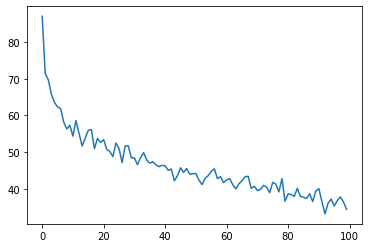

In [141]:
plt.plot(loss_history)

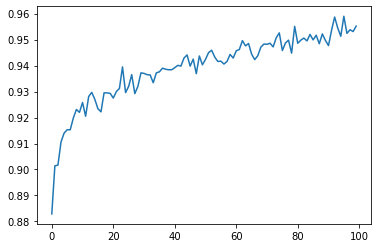

In [144]:
plt.plot([el / len(test_data) for el in correct_history])

In [128]:
model.eval()
test_dataloader = DataLoader(test_data, batch_size=1)

for img0, img1, label in test_dataloader:
    img0, img1, label = img0.to(device), img1.to(device), label.to(device)
    output1, output2 = model(img0, img1)
    loss_contrastive = criterion(output1, output2, label)
    break

In [129]:
loss_contrastive

tensor(0.0752, device='cuda:0', grad_fn=<MeanBackward0>)

In [130]:
F.pairwise_distance(output1, output2)

tensor([1.7258], device='cuda:0', grad_fn=<NormBackward1>)

In [131]:
label

tensor([[1.]], device='cuda:0')